In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

data_df = pd.read_csv("/kaggle/input/rice-type-classification/riceClassification.csv")

data_df.dropna(inplace = True)
data_df.drop(["id"], axis = 1, inplace = True)
original_df = data_df.copy()
for column in data_df.columns:
    data_df[column]=data_df[column]/data_df[column].abs().max()

X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:, -1])
X_train, X_temp,Y_train, Y_temp = train_test_split(X,Y,test_size = 0.3)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp,Y_temp,test_size = 0.5)

In [ ]:
class dataset(Dataset):
    def __init__(self,X,Y):
        self.X = torch.tensor(X,dtype = torch.float32).to(device)
        self.Y = torch.tensor(Y, dtype = torch.float32).to(device)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self,index):
        return self.X[index], self.Y[index]

training_data = dataset(X_train, Y_train)
validation_data = dataset(X_val, Y_val)
testing_data = dataset(X_test,Y_test)

train_dataloader = DataLoader(training_data, batch_size = 8, shuffle = True)
val_dataloader = DataLoader(validation_data, batch_size = 8, shuffle = True)
test_dataloader = DataLoader(testing_data, batch_size = 8, shuffle = True)


Hidden_Neurons = 10

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.input_layer = nn.Linear(X.shape[1],Hidden_Neurons)
        self.linear = nn.Linear(Hidden_Neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)
        

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr= 1e-3)
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []
epochs = 30

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for data in train_dataloader:
        inputs,labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss = criterion(prediction,labels) 
        total_loss_train += batch_loss.item()
        acc = ((prediction).round() == labels).sum().item()
        total_acc_train += acc
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    with torch.no_grad():
        for data in val_dataloader:
            inputs, label = data
            prediction = model(inputs).squeeze(1)
            val_loss = criterion(prediction, label)
            total_loss_val += val_loss.item()
            acc = ((prediction).round() == label).sum().item()
            total_acc_val += acc

         
    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))
    total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
    total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100, 4))
    print(f"""Epoch no.: {epoch+1} Train Loss: {(round(total_loss_train/1000,4))} Validation Loss : {(round(total_loss_val/1000,4))}
              Train accuracy: {round(total_acc_train/training_data.__len__()*100,4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100, 4)}    """)

In [ ]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for data in test_dataloader:
        inputs, labels = data
        prediction = model(inputs).squeeze(1)
        batch_loss_test = criterion(prediction, labels).item()
        total_loss_test += batch_loss_test
        acc = ((prediction).round() == labels).sum().item()
        total_acc_test += acc
print("Accuracy: ", round((total_acc_test / testing_data.__len__()) * 100, 4))

Epoch no.: 1 Train Loss: 0.5927 Validation Loss : 0.0826
              Train accuracy: 91.6019 Validation Accuracy: 98.5704    
Epoch no.: 2 Train Loss: 0.1247 Validation Loss : 0.0372
              Train accuracy: 98.4366 Validation Accuracy: 98.717    
Epoch no.: 3 Train Loss: 0.0787 Validation Loss : 0.029
              Train accuracy: 98.6173 Validation Accuracy: 98.662    
Epoch no.: 4 Train Loss: 0.069 Validation Loss : 0.0288
              Train accuracy: 98.5781 Validation Accuracy: 98.6437    
Epoch no.: 5 Train Loss: 0.065 Validation Loss : 0.0265
              Train accuracy: 98.6645 Validation Accuracy: 98.607    
Epoch no.: 6 Train Loss: 0.0632 Validation Loss : 0.0276
              Train accuracy: 98.7195 Validation Accuracy: 98.6437    
Epoch no.: 7 Train Loss: 0.0636 Validation Loss : 0.0258
              Train accuracy: 98.6488 Validation Accuracy: 98.6987    
Epoch no.: 8 Train Loss: 0.0625 Validation Loss : 0.0264
              Train accuracy: 98.6488 Validation Accu

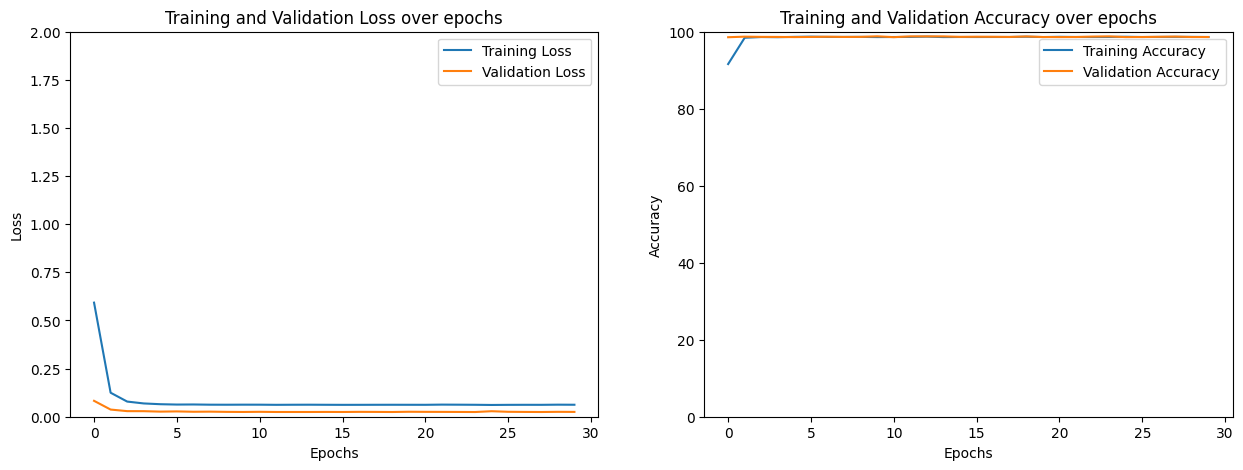

In [100]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot,label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_validation_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()
